# 8-2. 자율주행 보조장치 (1) KITTI 데이터셋
이번 시간에 만들어 볼 자율주행 보조장치는 카메라에 사람이 탐지되었을 때, 그리고 차가 가까워져서 탐지된 크기가 일정 크기 이상일 때를 판단해야 합니다.

- 자율주행 보조장치 object detection 요구사항

  1) 사람이 카메라에 감지되면 정지  
  2) 차량이 일정 크기 이상으로 감지되면 정지
  


- tensorflow_datasets에서 제공하는 KITTI 데이터셋 사용
  - 자율주행을 위한 데이터셋으로 2D object detection 뿐만 아니라 깊이까지 포함한 3D object detection 라벨 등을 제공

- 필요한 라이브러리 불러오기

In [1]:
import os, copy
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

DATA_PATH = os.getenv('HOME') + '/aiffel/object_detection/data'

print('슝=3')

슝=3


- KITTI 데이터셋 다운로드

In [2]:
(ds_train, ds_test), ds_info = tfds.load(
    'kitti',
    data_dir=DATA_PATH,
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)
print('슝=3')

슝=3


- 다운로드한 KITTI 데이터셋 확인: tfds.show_examples 사용

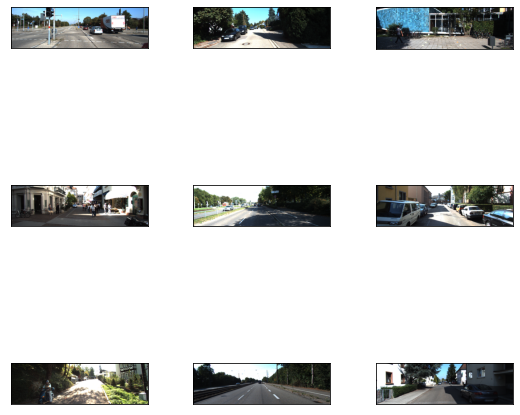

In [3]:
_ = tfds.show_examples(ds_train, ds_info)

- 데이터셋 정보 확인 (ds_info)... 주요 정보:
  - 6,347개의 학습 데이터(training data)
  - 711개의 평가용 데이터(test data)
  - 423개의 검증용 데이터(validation data)
  - 라벨에는 alpha, bbox, dimensions, location, occluded, rotation_y, truncated 등의 정보

In [4]:
ds_info

tfds.core.DatasetInfo(
    name='kitti',
    full_name='kitti/3.2.0',
    description="""
    Kitti contains a suite of vision tasks built using an autonomous driving
    platform. The full benchmark contains many tasks such as stereo, optical flow,
    visual odometry, etc. This dataset contains the object detection dataset,
    including the monocular images and bounding boxes. The dataset contains 7481
    training images annotated with 3D bounding boxes. A full description of the
    annotations can be found in the readme of the object development kit readme on
    the Kitti homepage.
    """,
    homepage='http://www.cvlibs.net/datasets/kitti/',
    data_path='/aiffel/aiffel/object_detection/data/kitti/3.2.0',
    download_size=11.71 GiB,
    dataset_size=5.27 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/file_name': Text(shape=(), dtype=tf.string),
        'objects': Sequence({
            'alpha': tf.float32,
     

# 8-3. 자율주행 보조장치 (2) 데이터 직접 확인하기

- 학습에 사용할 데이터 직접 이해하기

------Example------
['image', 'image/file_name', 'objects']
------objects------
{'alpha': <tf.Tensor: shape=(6,), dtype=float32, numpy=array([-0.86, -1.6 , -0.51,  1.44,  1.77,  1.94], dtype=float32)>, 'bbox': <tf.Tensor: shape=(6, 4), dtype=float32, numpy=
array([[0.0027027 , 0.        , 0.45554054, 0.24836601],
       [0.41256756, 0.8102206 , 0.60175675, 0.8412255 ],
       [0.45089188, 0.8252696 , 0.58402705, 0.96843135],
       [0.45332432, 0.3608987 , 0.53432435, 0.3954902 ],
       [0.4384054 , 0.29299837, 0.5387027 , 0.31436273],
       [0.39505404, 0.16185458, 0.51954055, 0.24050653]], dtype=float32)>, 'dimensions': <tf.Tensor: shape=(6, 3), dtype=float32, numpy=
array([[1.5 , 1.78, 3.69],
       [1.72, 0.78, 1.71],
       [1.51, 1.75, 4.45],
       [1.44, 1.64, 3.68],
       [1.87, 0.86, 2.12],
       [1.63, 1.78, 4.54]], dtype=float32)>, 'location': <tf.Tensor: shape=(6, 3), dtype=float32, numpy=
array([[ -3.16,   1.68,   3.35],
       [ 10.47,   0.9 ,  18.34],
       [ 16.09

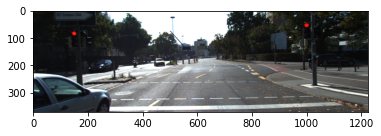

In [5]:
sample = ds_train.take(1)

for example in sample:  
    print('------Example------')
    print(list(example.keys()))
    image = example["image"]
    filename = example["image/file_name"].numpy().decode('utf-8')
    objects = example["objects"]

print('------objects------')
print(objects)

img = Image.fromarray(image.numpy())
plt.imshow(img)
plt.show()

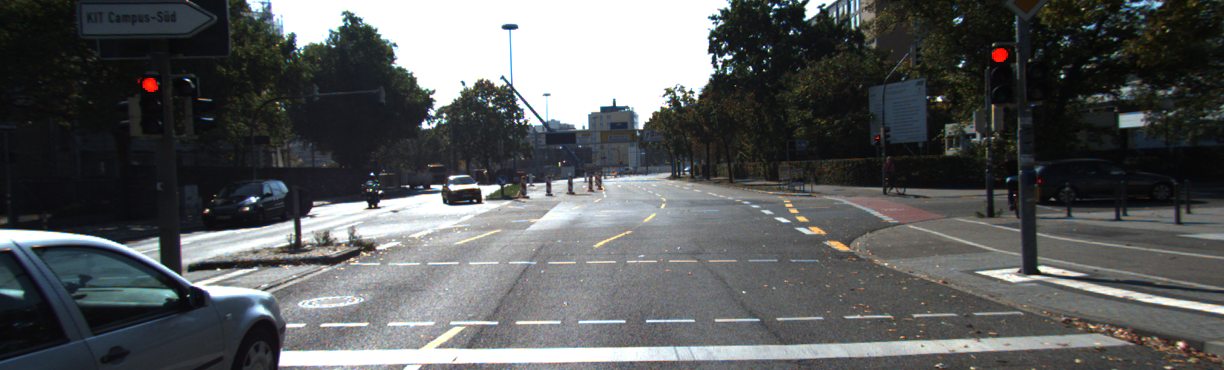

In [6]:
# 테스트 코드... plt.show() 보다 크게 디스플레이
img.show()

In [7]:
print(image)

tf.Tensor(
[[[20 30 24]
  [21 30 18]
  [21 27 14]
  ...
  [51 65 58]
  [43 52 52]
  [44 49 33]]

 [[19 28 23]
  [18 29 20]
  [18 27 18]
  ...
  [38 52 42]
  [43 42 34]
  [42 39 28]]

 [[33 33 24]
  [35 31 22]
  [30 29 19]
  ...
  [38 34 11]
  [41 28 17]
  [39 31 26]]

 ...

 [[33 45 58]
  [33 45 59]
  [33 46 59]
  ...
  [60 50 42]
  [69 52 43]
  [69 58 49]]

 [[33 47 58]
  [33 47 59]
  [34 47 58]
  ...
  [70 51 43]
  [72 52 42]
  [73 53 46]]

 [[33 47 57]
  [34 47 57]
  [35 46 57]
  ...
  [68 59 47]
  [71 52 46]
  [73 49 42]]], shape=(370, 1224, 3), dtype=uint8)


In [8]:
print(img)
print(img.size)
width, height = img.size
print(width, height)
print(img.format)
print(img.mode)
print(img.width)
print(img.height)

<PIL.Image.Image image mode=RGB size=1224x370 at 0x7F6EF9F50700>
(1224, 370)
1224 370
None
RGB
1224
370


- 이미지 위에 바운딩 박스를 그려기

(1224, 370)
(1224, 370)
[   0.       991.71    1010.12994  441.74002  358.63     198.11   ]
[369.      217.35    203.17    202.27    207.79001 223.83   ]
[ 304.      1029.66    1185.36     484.08002  384.78     294.38   ]
[201.45    147.35    153.90999 172.29999 170.68    177.77   ]
[[   0.       369.       304.       201.45   ]
 [ 991.71     217.35    1029.66     147.35   ]
 [1010.12994  203.17    1185.36     153.90999]
 [ 441.74002  202.27     484.08002  172.29999]
 [ 358.63     207.79001  384.78     170.68   ]
 [ 198.11     223.83     294.38     177.77   ]]


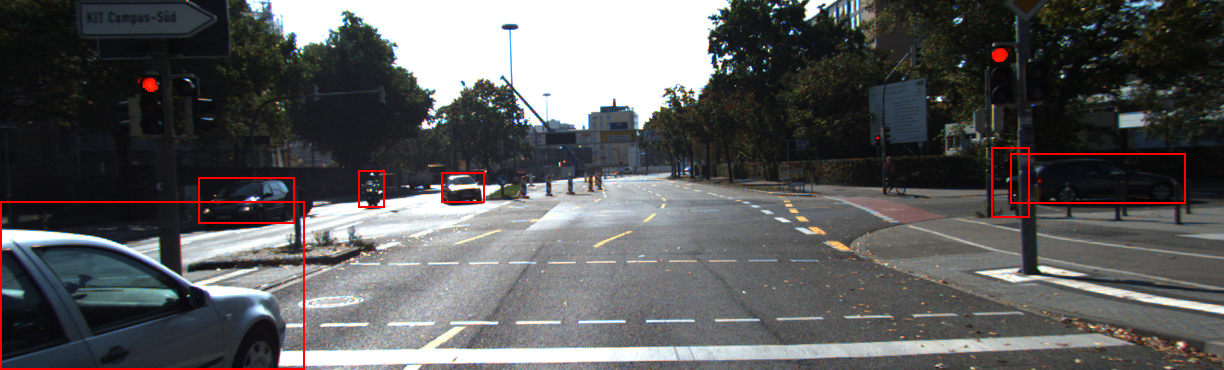

In [9]:
def visualize_bbox(input_image, object_bbox):
    input_image = copy.deepcopy(input_image)
    draw = ImageDraw.Draw(input_image)
    
    # 바운딩 박스 좌표(x_min, x_max, y_min, y_max) 구하기
    #width, height = img.size
    width, height = input_image.size # 코드 수정 필요 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    
    print(img.size)
    print(input_image.size)
    
    x_min = object_bbox[:,1] * width
    x_max = object_bbox[:,3] * width
    y_min = height - object_bbox[:,0] * height
    y_max = height - object_bbox[:,2] * height

    print(x_min)
    print(y_min)
    print(x_max)
    print(y_max)
    
    # 바운딩 박스 그리기
    rects = np.stack([x_min, y_min, x_max, y_max], axis=1)
    print(rects)
    
    for _rect in rects:
        draw.rectangle(_rect, outline=(255,0,0), width=2)

    return input_image

visualize_bbox(img, objects['bbox'].numpy())

# 8-4. RetinaNet
- Focal Loss for Dense Object Detection 논문을 통해 공개된 detection 모델
- 성능이 낮은 문제 해결을 위해서 focal loss와 FPN(Feature Pyramid Network)을 적용한 네트워크 사용

# 8-5. 데이터 준비

### 데이터 파이프 라인
- 주어진 KITTI 데이터를 학습에 맞는 형태로 바꾸기
- 데이터 파이프라인 구축 4단계
  - (1) x와 y좌표 위치 교체
  - (2) 무작위로 수평 뒤집기(Flip)
  - (3) 이미지 크기 조정 및 패딩 추가
  - (4) 좌표계를 [x_min, y_min, x_max, y_max]에서 [x_min, y_min, width, height]으로 수정

In [10]:
def swap_xy(boxes):
    return tf.stack([boxes[:, 1], boxes[:, 0], boxes[:, 3], boxes[:, 2]], axis=-1)

print('슝=3')

슝=3


In [11]:
def random_flip_horizontal(image, boxes):
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        boxes = tf.stack(
           [1 - boxes[:, 2], boxes[:, 1], 1 - boxes[:, 0], boxes[:, 3]], axis=-1
        )
        
    return image, boxes

print('슝=3')

슝=3


이미지 크기를 바꿀 때는 고려할 점이 있습니다. 이미지의 비율은 그대로 유지되어야 하고, 이미지의 최대/최소 크기도 제한해야 하거든요. 또 이미지의 크기를 바꾼 후에도 최종적으로 모델에 입력되는 이미지의 크기는 stride의 배수가 되도록 만들 거예요.

예를 들어 600x720 크기의 이미지가 있다면 800x960 크기로 바꿀 수 있습니다. 여기에 stride를 128로 놓아 800x960 크기의 이미지에 패딩을 더해 896x1024 크기의 이미지로 모델에 입력하겠다는 이야깁니다. 모델에 입력되는 이미지에는 검정 테두리가 있겠군요!

실제로 입력할 이미지를 어떻게 바꿀지는 min_side, max_side, min_side_range, stride등에 의해 결정돼요. 그리고 학습이 완료된 모델을 사용할 때는 입력할 이미지를 다양한 크기로 바꿀 필요는 없으니 분기처리를 해줍니다.

In [12]:
def resize_and_pad_image(image, training=True):

    min_side = 800.0
    max_side = 1333.0
    min_side_range = [640, 1024]
    stride = 128.0
    
    image_shape = tf.cast(tf.shape(image)[:2], dtype=tf.float32)
    if training:
        min_side = tf.random.uniform((), min_side_range[0], min_side_range[1], dtype=tf.float32)
    ratio = min_side / tf.reduce_min(image_shape)
    if ratio * tf.reduce_max(image_shape) > max_side:
        ratio = max_side / tf.reduce_max(image_shape)
    image_shape = ratio * image_shape
    image = tf.image.resize(image, tf.cast(image_shape, dtype=tf.int32))
    padded_image_shape = tf.cast(
        tf.math.ceil(image_shape / stride) * stride, dtype=tf.int32
    )
    image = tf.image.pad_to_bounding_box(
        image, 0, 0, padded_image_shape[0], padded_image_shape[1]
    )
    return image, image_shape, ratio

print('슝=3')

슝=3


In [13]:
def convert_to_xywh(boxes):
    return tf.concat(
        [(boxes[..., :2] + boxes[..., 2:]) / 2.0, boxes[..., 2:] - boxes[..., :2]],
        axis=-1,
    )

print('슝=3')

슝=3


- 준비된 함수들을 연결

In [14]:
def preprocess_data(sample):
    image = sample["image"]
    bbox = swap_xy(sample["objects"]["bbox"])
    class_id = tf.cast(sample["objects"]["type"], dtype=tf.int32)

    image, bbox = random_flip_horizontal(image, bbox)
    image, image_shape, _ = resize_and_pad_image(image)

    bbox = tf.stack(
        [
            bbox[:, 0] * image_shape[1],
            bbox[:, 1] * image_shape[0],
            bbox[:, 2] * image_shape[1],
            bbox[:, 3] * image_shape[0],
        ],
        axis=-1,
    )
    bbox = convert_to_xywh(bbox)
    return image, bbox, class_id

print('슝=3')

슝=3


### 인코딩
- Anchor Box 생성

In [15]:
class AnchorBox:
    def __init__(self):
        self.aspect_ratios = [0.5, 1.0, 2.0]
        self.scales = [2 ** x for x in [0, 1 / 3, 2 / 3]]

        self._num_anchors = len(self.aspect_ratios) * len(self.scales)
        self._strides = [2 ** i for i in range(3, 8)]
        self._areas = [x ** 2 for x in [32.0, 64.0, 128.0, 256.0, 512.0]]
        self._anchor_dims = self._compute_dims()

    def _compute_dims(self):
        anchor_dims_all = []
        for area in self._areas:
            anchor_dims = []
            for ratio in self.aspect_ratios:
                anchor_height = tf.math.sqrt(area / ratio)
                anchor_width = area / anchor_height
                dims = tf.reshape(
                    tf.stack([anchor_width, anchor_height], axis=-1), [1, 1, 2]
                )
                for scale in self.scales:
                    anchor_dims.append(scale * dims)
            anchor_dims_all.append(tf.stack(anchor_dims, axis=-2))
        return anchor_dims_all

    def _get_anchors(self, feature_height, feature_width, level):
        rx = tf.range(feature_width, dtype=tf.float32) + 0.5
        ry = tf.range(feature_height, dtype=tf.float32) + 0.5
        centers = tf.stack(tf.meshgrid(rx, ry), axis=-1) * self._strides[level - 3]
        centers = tf.expand_dims(centers, axis=-2)
        centers = tf.tile(centers, [1, 1, self._num_anchors, 1])
        dims = tf.tile(
            self._anchor_dims[level - 3], [feature_height, feature_width, 1, 1]
        )
        anchors = tf.concat([centers, dims], axis=-1)
        return tf.reshape(
            anchors, [feature_height * feature_width * self._num_anchors, 4]
        )

    def get_anchors(self, image_height, image_width):
        anchors = [
            self._get_anchors(
                tf.math.ceil(image_height / 2 ** i),
                tf.math.ceil(image_width / 2 ** i),
                i,
            )
            for i in range(3, 8)
        ]
        return tf.concat(anchors, axis=0)

print('슝=3')

슝=3


- IoU 계산

In [16]:
def convert_to_corners(boxes):
    return tf.concat(
        [boxes[..., :2] - boxes[..., 2:] / 2.0, boxes[..., :2] + boxes[..., 2:] / 2.0],
        axis=-1,
    )

def compute_iou(boxes1, boxes2):
    boxes1_corners = convert_to_corners(boxes1)
    boxes2_corners = convert_to_corners(boxes2)
    lu = tf.maximum(boxes1_corners[:, None, :2], boxes2_corners[:, :2])
    rd = tf.minimum(boxes1_corners[:, None, 2:], boxes2_corners[:, 2:])
    intersection = tf.maximum(0.0, rd - lu)
    intersection_area = intersection[:, :, 0] * intersection[:, :, 1]
    boxes1_area = boxes1[:, 2] * boxes1[:, 3]
    boxes2_area = boxes2[:, 2] * boxes2[:, 3]
    union_area = tf.maximum(
        boxes1_area[:, None] + boxes2_area - intersection_area, 1e-8
    )
    return tf.clip_by_value(intersection_area / union_area, 0.0, 1.0)

print('슝=3')

슝=3


- 실제 라벨을 Anchor Box에 맞춰주는 클래스 구성
  - variance: 상하좌우의 차이에는 0.1, 가로세로 크기의 차이에는 0.2를 사용
  - IoU가 0.5보다 높으면 물체, 0.4보다 낮으면 배경

In [17]:
class LabelEncoder:

    def __init__(self):
        self._anchor_box = AnchorBox()
        self._box_variance = tf.convert_to_tensor(
            [0.1, 0.1, 0.2, 0.2], dtype=tf.float32
        )

    def _match_anchor_boxes(
        self, anchor_boxes, gt_boxes, match_iou=0.5, ignore_iou=0.4
    ):
        iou_matrix = compute_iou(anchor_boxes, gt_boxes)
        max_iou = tf.reduce_max(iou_matrix, axis=1)
        matched_gt_idx = tf.argmax(iou_matrix, axis=1)
        positive_mask = tf.greater_equal(max_iou, match_iou)
        negative_mask = tf.less(max_iou, ignore_iou)
        ignore_mask = tf.logical_not(tf.logical_or(positive_mask, negative_mask))
        return (
            matched_gt_idx,
            tf.cast(positive_mask, dtype=tf.float32),
            tf.cast(ignore_mask, dtype=tf.float32),
        )

    def _compute_box_target(self, anchor_boxes, matched_gt_boxes):
        box_target = tf.concat(
            [
                (matched_gt_boxes[:, :2] - anchor_boxes[:, :2]) / anchor_boxes[:, 2:],
                tf.math.log(matched_gt_boxes[:, 2:] / anchor_boxes[:, 2:]),
            ],
            axis=-1,
        )
        box_target = box_target / self._box_variance
        return box_target

    def _encode_sample(self, image_shape, gt_boxes, cls_ids):
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
        cls_ids = tf.cast(cls_ids, dtype=tf.float32)
        matched_gt_idx, positive_mask, ignore_mask = self._match_anchor_boxes(
            anchor_boxes, gt_boxes
        )
        matched_gt_boxes = tf.gather(gt_boxes, matched_gt_idx)
        box_target = self._compute_box_target(anchor_boxes, matched_gt_boxes)
        matched_gt_cls_ids = tf.gather(cls_ids, matched_gt_idx)
        cls_target = tf.where(
            tf.not_equal(positive_mask, 1.0), -1.0, matched_gt_cls_ids
        )
        cls_target = tf.where(tf.equal(ignore_mask, 1.0), -2.0, cls_target)
        cls_target = tf.expand_dims(cls_target, axis=-1)
        label = tf.concat([box_target, cls_target], axis=-1)
        return label

    def encode_batch(self, batch_images, gt_boxes, cls_ids):
        images_shape = tf.shape(batch_images)
        batch_size = images_shape[0]

        labels = tf.TensorArray(dtype=tf.float32, size=batch_size, dynamic_size=True)
        for i in range(batch_size):
            label = self._encode_sample(images_shape, gt_boxes[i], cls_ids[i])
            labels = labels.write(i, label)
        batch_images = tf.keras.applications.resnet.preprocess_input(batch_images)
        return batch_images, labels.stack()
    
print('슝=3')

슝=3


# 8-6. 모델 작성
### Feature Pyramid
- FPN(Feature Pyramid Network) 구성
  - FPN을 약간 수정

In [18]:
class FeaturePyramid(tf.keras.layers.Layer):

    def __init__(self, backbone):
        super(FeaturePyramid, self).__init__(name="FeaturePyramid")
        self.backbone = backbone
        self.conv_c3_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c4_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c5_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c3_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c4_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c5_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c6_3x3 = tf.keras.layers.Conv2D(256, 3, 2, "same")
        self.conv_c7_3x3 = tf.keras.layers.Conv2D(256, 3, 2, "same")
        self.upsample_2x = tf.keras.layers.UpSampling2D(2)

    def call(self, images, training=False):
        c3_output, c4_output, c5_output = self.backbone(images, training=training)
        p3_output = self.conv_c3_1x1(c3_output)
        p4_output = self.conv_c4_1x1(c4_output)
        p5_output = self.conv_c5_1x1(c5_output)
        p4_output = p4_output + self.upsample_2x(p5_output)
        p3_output = p3_output + self.upsample_2x(p4_output)
        p3_output = self.conv_c3_3x3(p3_output)
        p4_output = self.conv_c4_3x3(p4_output)
        p5_output = self.conv_c5_3x3(p5_output)
        p6_output = self.conv_c6_3x3(c5_output)
        p7_output = self.conv_c7_3x3(tf.nn.relu(p6_output))
        return p3_output, p4_output, p5_output, p6_output, p7_output

print('슝=3')

슝=3


- build_head 함수 구성
  - class를 예측하는 head와 box를 예측하는 head가 별도로 존재
  - 함수는 하나만 만들고 두 번 호출

In [19]:
def build_head(output_filters, bias_init):
    head = tf.keras.Sequential([tf.keras.Input(shape=[None, None, 256])])
    kernel_init = tf.initializers.RandomNormal(0.0, 0.01)
    for _ in range(4):
        head.add(
            tf.keras.layers.Conv2D(256, 3, padding="same", kernel_initializer=kernel_init)
        )
        head.add(tf.keras.layers.ReLU())
    head.add(
        tf.keras.layers.Conv2D(
            output_filters,
            3,
            1,
            padding="same",
            kernel_initializer=kernel_init,
            bias_initializer=bias_init,
        )
    )
    return head

print('슝=3')

슝=3


- Backbone 구성
  - ResNet50
  - FPN에 이용할 수 있도록 중간 레이어도 output으로 연결

In [20]:
def get_backbone():
    backbone = tf.keras.applications.ResNet50(
        include_top=False, input_shape=[None, None, 3]
    )
    c3_output, c4_output, c5_output = [
        backbone.get_layer(layer_name).output
        for layer_name in ["conv3_block4_out", "conv4_block6_out", "conv5_block3_out"]
    ]
    return tf.keras.Model(
        inputs=[backbone.inputs], outputs=[c3_output, c4_output, c5_output]
    )

print('슝=3')

슝=3


- RetinaNet 완성
  - Backbone + FPN + classification용 head + box용 head

In [21]:
class RetinaNet(tf.keras.Model):

    def __init__(self, num_classes, backbone):
        super(RetinaNet, self).__init__(name="RetinaNet")
        self.fpn = FeaturePyramid(backbone)
        self.num_classes = num_classes

        prior_probability = tf.constant_initializer(-np.log((1 - 0.01) / 0.01))
        self.cls_head = build_head(9 * num_classes, prior_probability)
        self.box_head = build_head(9 * 4, "zeros")

    def call(self, image, training=False):
        features = self.fpn(image, training=training)
        N = tf.shape(image)[0]
        cls_outputs = []
        box_outputs = []
        for feature in features:
            box_outputs.append(tf.reshape(self.box_head(feature), [N, -1, 4]))
            cls_outputs.append(
                tf.reshape(self.cls_head(feature), [N, -1, self.num_classes])
            )
        cls_outputs = tf.concat(cls_outputs, axis=1)
        box_outputs = tf.concat(box_outputs, axis=1)
        return tf.concat([box_outputs, cls_outputs], axis=-1)

print('슝=3')

슝=3


- Loss 함수 구성
  - Classification: Focal Loss 사용 (alpha와 gamma를 사용해서 물체일 때와 배경일 때의 식이 달라짐)
  - Box Regression: Smooth L1 Loss 사용 (delta를 기준으로 계산이 달라짐)

In [22]:
class RetinaNetBoxLoss(tf.losses.Loss):

    def __init__(self, delta):
        super(RetinaNetBoxLoss, self).__init__(
            reduction="none", name="RetinaNetBoxLoss"
        )
        self._delta = delta

    def call(self, y_true, y_pred):
        difference = y_true - y_pred
        absolute_difference = tf.abs(difference)
        squared_difference = difference ** 2
        loss = tf.where(
            tf.less(absolute_difference, self._delta),
            0.5 * squared_difference,
            absolute_difference - 0.5,
        )
        return tf.reduce_sum(loss, axis=-1)


class RetinaNetClassificationLoss(tf.losses.Loss):

    def __init__(self, alpha, gamma):
        super(RetinaNetClassificationLoss, self).__init__(
            reduction="none", name="RetinaNetClassificationLoss"
        )
        self._alpha = alpha
        self._gamma = gamma

    def call(self, y_true, y_pred):
        cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(
            labels=y_true, logits=y_pred
        )
        probs = tf.nn.sigmoid(y_pred)
        alpha = tf.where(tf.equal(y_true, 1.0), self._alpha, (1.0 - self._alpha))
        pt = tf.where(tf.equal(y_true, 1.0), probs, 1 - probs)
        loss = alpha * tf.pow(1.0 - pt, self._gamma) * cross_entropy
        return tf.reduce_sum(loss, axis=-1)


class RetinaNetLoss(tf.losses.Loss):

    def __init__(self, num_classes=8, alpha=0.25, gamma=2.0, delta=1.0):
        super(RetinaNetLoss, self).__init__(reduction="auto", name="RetinaNetLoss")
        self._clf_loss = RetinaNetClassificationLoss(alpha, gamma)
        self._box_loss = RetinaNetBoxLoss(delta)
        self._num_classes = num_classes

    def call(self, y_true, y_pred):
        y_pred = tf.cast(y_pred, dtype=tf.float32)
        box_labels = y_true[:, :, :4]
        box_predictions = y_pred[:, :, :4]
        cls_labels = tf.one_hot(
            tf.cast(y_true[:, :, 4], dtype=tf.int32),
            depth=self._num_classes,
            dtype=tf.float32,
        )
        cls_predictions = y_pred[:, :, 4:]
        positive_mask = tf.cast(tf.greater(y_true[:, :, 4], -1.0), dtype=tf.float32)
        ignore_mask = tf.cast(tf.equal(y_true[:, :, 4], -2.0), dtype=tf.float32)
        clf_loss = self._clf_loss(cls_labels, cls_predictions)
        box_loss = self._box_loss(box_labels, box_predictions)
        clf_loss = tf.where(tf.equal(ignore_mask, 1.0), 0.0, clf_loss)
        box_loss = tf.where(tf.equal(positive_mask, 1.0), box_loss, 0.0)
        normalizer = tf.reduce_sum(positive_mask, axis=-1)
        clf_loss = tf.math.divide_no_nan(tf.reduce_sum(clf_loss, axis=-1), normalizer)
        box_loss = tf.math.divide_no_nan(tf.reduce_sum(box_loss, axis=-1), normalizer)
        loss = clf_loss + box_loss
        return loss

print('슝=3')

슝=3


# 8-7. 모델 학습
- 모델 조립

In [23]:
num_classes = 8
batch_size = 2

resnet50_backbone = get_backbone()
loss_fn = RetinaNetLoss(num_classes)
model = RetinaNet(num_classes, resnet50_backbone)

print('슝=3')

94781440/94765736 [==============================] - 0s 0us/step
슝=3


- 모델 컴파일
  - Learning Rate 조정
  - Optimizer: SGD

In [24]:
learning_rates = [2.5e-06, 0.000625, 0.00125, 0.0025, 0.00025, 2.5e-05]
learning_rate_boundaries = [125, 250, 500, 240000, 360000]
learning_rate_fn = tf.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=learning_rate_boundaries, values=learning_rates
)
optimizer = tf.optimizers.SGD(learning_rate=learning_rate_fn, momentum=0.9)
model.compile(loss=loss_fn, optimizer=optimizer)

- 데이터 전처리를 위한 파이프라인 생성

In [25]:
label_encoder = LabelEncoder()
(train_dataset, val_dataset), dataset_info = tfds.load(
    "kitti", split=["train", "validation"], with_info=True, data_dir=DATA_PATH
)

autotune = tf.data.AUTOTUNE
train_dataset = train_dataset.map(preprocess_data, num_parallel_calls=autotune)
train_dataset = train_dataset.shuffle(8 * batch_size)
train_dataset = train_dataset.padded_batch(
    batch_size=batch_size, padding_values=(0.0, 1e-8, -1), drop_remainder=True
)
train_dataset = train_dataset.map(
    label_encoder.encode_batch, num_parallel_calls=autotune
)
train_dataset = train_dataset.prefetch(autotune)

val_dataset = val_dataset.map(preprocess_data, num_parallel_calls=autotune)
val_dataset = val_dataset.padded_batch(
    batch_size=1, padding_values=(0.0, 1e-8, -1), drop_remainder=True
)
val_dataset = val_dataset.map(label_encoder.encode_batch, num_parallel_calls=autotune)
val_dataset = val_dataset.prefetch(autotune)

print('슝=3')

슝=3


- 모델 훈련(학습)
  - 1 epoch당 학습 시간이 상당히 오래 걸리기 때문에 여기서는 학습시키는 예시 코드만 제시
  - 뒤에선 미리 학습된 모델을 불러와 사용할 예정 😙

In [26]:
"""
model_dir = os.getenv('HOME') + '/aiffel/object_detection/data/checkpoints/'
callbacks_list = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(model_dir, "weights" + "_epoch_{epoch}"),
        monitor="loss",
        save_best_only=False,
        save_weights_only=True,
        verbose=1,
    )
]

epochs = 1

model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=callbacks_list
)
"""

'\nmodel_dir = os.getenv(\'HOME\') + \'/aiffel/object_detection/data/checkpoints/\'\ncallbacks_list = [\n    tf.keras.callbacks.ModelCheckpoint(\n        filepath=os.path.join(model_dir, "weights" + "_epoch_{epoch}"),\n        monitor="loss",\n        save_best_only=False,\n        save_weights_only=True,\n        verbose=1,\n    )\n]\n\nepochs = 1\n\nmodel.fit(\n    train_dataset,\n    validation_data=val_dataset,\n    epochs=epochs,\n    callbacks=callbacks_list\n)\n'

# 8-8. 결과 확인하기
- 미리 학습된 모델 불러오기

In [27]:
model_dir = os.getenv('HOME') + '/aiffel/object_detection/data/checkpoints/'
latest_checkpoint = tf.train.latest_checkpoint(model_dir)
model.load_weights(latest_checkpoint)

print('슝=3')

슝=3


- 모델의 추론 결과를 처리할 함수를 레이어 형식으로 구성
  - 100개의 후보만 골라 처리
    - 0.05보다 높은 box 100개를 골라 0.5 NMS를 진행
    
  - NMS(Non-Max Suppression)은 tf.image.combined_non_max_suppression 사용
    - nmsed_boxes, nmsed_scores, nmsed_classes, valid_detections를 반환(return)

In [28]:
class DecodePredictions(tf.keras.layers.Layer):

    def __init__(
        self,
        num_classes=8,
        confidence_threshold=0.05,
        nms_iou_threshold=0.5,
        max_detections_per_class=100,
        max_detections=100,
        box_variance=[0.1, 0.1, 0.2, 0.2]
    ):
        super(DecodePredictions, self).__init__()
        self.num_classes = num_classes
        self.confidence_threshold = confidence_threshold
        self.nms_iou_threshold = nms_iou_threshold
        self.max_detections_per_class = max_detections_per_class
        self.max_detections = max_detections

        self._anchor_box = AnchorBox()
        self._box_variance = tf.convert_to_tensor(
            box_variance, dtype=tf.float32
        )

    def _decode_box_predictions(self, anchor_boxes, box_predictions):
        boxes = box_predictions * self._box_variance
        boxes = tf.concat(
            [
                boxes[:, :, :2] * anchor_boxes[:, :, 2:] + anchor_boxes[:, :, :2],
                tf.math.exp(boxes[:, :, 2:]) * anchor_boxes[:, :, 2:],
            ],
            axis=-1,
        )
        boxes_transformed = convert_to_corners(boxes)
        return boxes_transformed

    def call(self, images, predictions):
        image_shape = tf.cast(tf.shape(images), dtype=tf.float32)
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
        box_predictions = predictions[:, :, :4]
        cls_predictions = tf.nn.sigmoid(predictions[:, :, 4:])
        boxes = self._decode_box_predictions(anchor_boxes[None, ...], box_predictions)

        return tf.image.combined_non_max_suppression(
            tf.expand_dims(boxes, axis=2),
            cls_predictions,
            self.max_detections_per_class,
            self.max_detections,
            self.nms_iou_threshold,
            self.confidence_threshold,
            clip_boxes=False,
        )

print('슝=3')

슝=3


- 추론 모델 조립

In [29]:
image = tf.keras.Input(shape=[None, None, 3], name="image")
predictions = model(image, training=False)
detections = DecodePredictions(confidence_threshold=0.5)(image, predictions)
inference_model = tf.keras.Model(inputs=image, outputs=detections)

print('슝=3')

슝=3


- 모델의 추론 결과 시각화

In [30]:
def visualize_detections(
    image, boxes, classes, scores, figsize=(7, 7), linewidth=1, color=[0, 0, 1]
):
    image = np.array(image, dtype=np.uint8)
    plt.figure(figsize=figsize)
    plt.axis("off")
    plt.imshow(image)
    ax = plt.gca()
    for box, _cls, score in zip(boxes, classes, scores):
        text = "{}: {:.2f}".format(_cls, score)
        x1, y1, x2, y2 = box
        w, h = x2 - x1, y2 - y1
        patch = plt.Rectangle(
            [x1, y1], w, h, fill=False, edgecolor=color, linewidth=linewidth
        )
        ax.add_patch(patch)
        ax.text(
            x1,
            y1,
            text,
            bbox={"facecolor": color, "alpha": 0.4},
            clip_box=ax.clipbox,
            clip_on=True,
        )
    plt.show()
    return ax

print('슝=3')

슝=3


- 추론 입력 데이터 전처리 함수

In [31]:
def prepare_image(image):
    image, _, ratio = resize_and_pad_image(image, training=False)
    image = tf.keras.applications.resnet.preprocess_input(image)
    return tf.expand_dims(image, axis=0), ratio

print('슝=3')

슝=3


- 학습된 결과 확인!!

CombinedNonMaxSuppression(nmsed_boxes=array([[[578.17865, 163.55217, 629.83685, 210.95714],
        [  0.     ,   0.     ,   0.     ,   0.     ],
        [  0.     ,   0.     ,   0.     ,   0.     ],
        [  0.     ,   0.     ,   0.     ,   0.     ],
        [  0.     ,   0.     ,   0.     ,   0.     ],
        [  0.     ,   0.     ,   0.     ,   0.     ],
        [  0.     ,   0.     ,   0.     ,   0.     ],
        [  0.     ,   0.     ,   0.     ,   0.     ],
        [  0.     ,   0.     ,   0.     ,   0.     ],
        [  0.     ,   0.     ,   0.     ,   0.     ],
        [  0.     ,   0.     ,   0.     ,   0.     ],
        [  0.     ,   0.     ,   0.     ,   0.     ],
        [  0.     ,   0.     ,   0.     ,   0.     ],
        [  0.     ,   0.     ,   0.     ,   0.     ],
        [  0.     ,   0.     ,   0.     ,   0.     ],
        [  0.     ,   0.     ,   0.     ,   0.     ],
        [  0.     ,   0.     ,   0.     ,   0.     ],
        [  0.     ,   0.     ,   0.     ,   

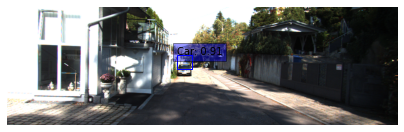

CombinedNonMaxSuppression(nmsed_boxes=array([[[203.23477 , 129.49358 , 346.98166 , 200.10774 ],
        [614.61127 , 175.55824 , 649.9234  , 204.8802  ],
        [317.85388 , 148.21446 , 392.97534 , 195.80397 ],
        [394.0982  , 135.78232 , 529.5347  , 281.0891  ],
        [-11.18222 ,  11.339554, 318.15726 , 184.18718 ],
        [  0.      ,   0.      ,   0.      ,   0.      ],
        [  0.      ,   0.      ,   0.      ,   0.      ],
        [  0.      ,   0.      ,   0.      ,   0.      ],
        [  0.      ,   0.      ,   0.      ,   0.      ],
        [  0.      ,   0.      ,   0.      ,   0.      ],
        [  0.      ,   0.      ,   0.      ,   0.      ],
        [  0.      ,   0.      ,   0.      ,   0.      ],
        [  0.      ,   0.      ,   0.      ,   0.      ],
        [  0.      ,   0.      ,   0.      ,   0.      ],
        [  0.      ,   0.      ,   0.      ,   0.      ],
        [  0.      ,   0.      ,   0.      ,   0.      ],
        [  0.      ,   0.      ,  

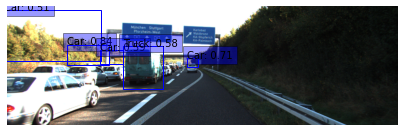

In [32]:
test_dataset = tfds.load("kitti", split="test", data_dir=DATA_PATH)
int2str = dataset_info.features["objects"]["type"].int2str

for sample in test_dataset.take(2):
    image = tf.cast(sample["image"], dtype=tf.float32)
    input_image, ratio = prepare_image(image)
    detections = inference_model.predict(input_image)
    
    print(detections)
    
    num_detections = detections.valid_detections[0]
    class_names = [
        int2str(int(x)) for x in detections.nmsed_classes[0][:num_detections]
    ]
    visualize_detections(
        image,
        detections.nmsed_boxes[0][:num_detections] / ratio,
        class_names,
        detections.nmsed_scores[0][:num_detections],
    )

In [33]:
print(int2str)

<bound method ClassLabel.int2str of ClassLabel(shape=(), dtype=tf.int64, num_classes=8)>


# 8-9. 프로젝트: 자율주행 보조 시스템 만들기
먼저 주요 라이브러리 버전을 확인해봅시다.

## 1. 자율주행 시스템 만들기
위에서 만든 모델을 통해 아래의 조건을 만족하는 함수를 만들어 주세요.

- 입력으로 이미지 경로를 받습니다.
- 정지조건에 맞는 경우 "Stop" 아닌 경우 "Go"를 반환합니다.
- 조건은 다음과 같습니다.
  - 사람이 한 명 이상 있는 경우
  - 차량의 크기(width or height)가 300px이상인 경우

In [ ]:
img_path = os.getenv('HOME')+'/aiffel/object_detection/data/stop_1.png'
#DATA_PATH = os.getenv('HOME') + '/aiffel/object_detection/data'

In [ ]:
def self_drive_assist(img_path, size_limit=300):
    # 코드 구현
        # 정지조건에 맞으면 return "Stop"
        # 아닌 경우 return "Go"

print(self_drive_assist(img_path))

## 2. 자율주행 시스템 평가하기
아래 test_system() 를 통해서 위에서 만든 함수를 평가해봅시다. 10장에 대해 Go와 Stop을 맞게 반환하는지 확인하고 100점 만점으로 평가해줍니다.

In [ ]:
import os

def test_system(func):
    work_dir = os.getenv('HOME')+'/aiffel/object_detection/data'
    score = 0
    test_set=[
        ("stop_1.png", "Stop"),
        ("stop_2.png", "Stop"),
        ("stop_3.png", "Stop"),
        ("stop_4.png", "Stop"),
        ("stop_5.png", "Stop"),
        ("go_1.png", "Go"),
        ("go_2.png", "Go"),
        ("go_3.png", "Go"),
        ("go_4.png", "Go"),
        ("go_5.png", "Go"),
    ]
    
    for image_file, answer in test_set:
        image_path = work_dir + '/' + image_file
        pred = func(image_path)
        if pred == answer:
            score += 10
    print(f"{score}점입니다.")

test_system(self_drive_assist)

## 프로젝트 평가

| 평가문항 | 상세기준 | 수행 결과 |
|:---|:---|:---|
| 1. KITTI 데이터셋에 대한 분석이 체계적으로 진행되었다. | KITTI 데이터셋 구조와 내용을 파악하고 이를 토대로 필요한 데이터셋 가공을 정상 진행하였다. | 교재대로 함 |
| 2. RetinaNet 학습이 정상적으로 진행되어 object detection 결과의 시각화까지 진행되었다. |  바운딩박스가 정확히 표시된 시각화된 이미지를 생성하였다. | 교재대로 한 결과 바운딩 박스가 엉뚱한 곳에 표시됨 |
| 3. 자율주행 Object Detection 테스트시스템 적용결과 만족스러운 정확도 성능을 달성하였다. | 테스트 수행결과 90% 이상의 정확도를 보였다. | 내용을 이해하지 못하여 코드 작성을 못함 | 


### 회고
- RetinaNet 내용을 이해하지 못했다.
- Node #07의 내용도 Andrew Ng교수의 유투브(C4W3L01~L10 Object Detection)를 통해 이해했다.
- Object Detection에 대한 개념적인 이해를 바탕으로 YOLO 등과 같은 Object Detection의 기본이 되는 모델 구현을 통해 Input/output, 모델 구조, 손실함수 등을 이해하는 것이 필요할 것 같다.
- 이러한 과정없이 기본 모델을 개선한 모델(RetinaNet)로 점프해서 이해가 더 어려운 것 같다.
- 교재의 내용을 기반으로 기본적으로 알아야 하는 Input/Output 등에 대해 이해하고자 했으나 어렵다.
- 이러한 것들을 자습과 팀 학습으로 해결하기는 어렵다 (제한된 시간에 너무 많은 내용이 쏟아져서 등).
- 교재의 코드대로 실행한 결과에서도 바운딩박스가 정확히 표시되지 않는다.
- Input/Output을 하나 하나 뜯어보고 관련 논문도 보고 한다면 이해할 수 있을 것이다.
- 지난 Project에서도 느꼈지만 Tensorflow를 포함하여 Open CV, Pillow 등에 대한 기본적인 사항들도 알아야 한다.
- 종합하면, 공부해야 할 내용에 비해 주어진 시간이 부족하고, 교재에 제시되는 내용과 Guide도 아쉽다.